# NER using LSTM

after several failed attempts, I will be using LSTM, I'm following the following tutorial for this:
https://www.depends-on-the-definition.com/lstm-with-char-embeddings-for-ner/



In [ ]:
# importing stuffs

import json
import numpy as np
import pandas as pd
# importing regex
import re

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/NLP/main.jsonl", 'r') as jsonl_file:
  jsonl_list = list(jsonl_file)

In [ ]:
# creating two list to store the sentence and annotation
# which will later be included into a dataframe

s_list = [] # sentence list
t_list = [] # annotation list

for jsonl_string in jsonl_list:
  json_values = json.loads(jsonl_string)
  s_list.append(json_values[0])
  t_list.append(json_values[1])
  # print(jsonl_string)

### primary dataframe for data preprocessing

In [ ]:
dfp = pd.DataFrame()

In [ ]:
dfp['sentence'] = s_list

# converting the tag list into string
t_string_list = [' '.join(tags) for tags in t_list]

# dfp['tag'] = t_list
dfp['tag string'] = t_string_list
dfp.head()

sentence  \
0  অগ্রণী ব্যাংকের জ্যেষ্ঠ কর্মকর্তা পদে নিয়োগ প...   
1  ব্যাংকের চেয়ারম্যানও এ অভিযোগের সত্যতা স্বীকা...   
2  আজ শুক্রবার বিকেল চারটা থেকে পাঁচটা পর্যন্ত এক...   
3  এ ছাড়া কয়েকটি পরীক্ষাকেন্দ্রে ছাত্রলীগের নেত...   
4  ব্যাংকের চেয়ারম্যান ও ঢাকা বিশ্ববিদ্যালয়ের ই...   

                                          tag string  
0                    B-ORG L-ORG O O O O O O O O O O  
1                                    O O O O O O O O  
2                        O O O O O O O O O O O O O O  
3                O O O O U-ORG O O O O O O O O O O O  
4  O O O B-ORG L-ORG B-ORG I-ORG L-ORG B-PERSON I...

#### finiding all duplicates

In [ ]:
dfp[dfp.duplicated()]

sentence  \
161                                         খবর বাসসের।   
932   জেলা ও দায়রা জজ এবং অতিরিক্ত জেলা ও দায়রা জজ...   
935   জেলা ও দায়রা জজ এবং অতিরিক্ত জেলা ও দায়রা জজ...   
943   এখানে একটি আলোচনা সভাও আয়োজন করেছিল ঢাকা বিশ্...   
950   পাউবোর অভিযোগ, আন্তসংস্থার একাধিক সভায় বাঁধের...   
...                                                 ...   
2270  সরকারের পক্ষ থেকে গতকাল বুধবার এবং গত মঙ্গলবার...   
2274  বিএনপির চেয়ারপারসনের এই উপদেষ্টা দাবি করেন, গ...   
2331  এর মধ্যে ঘূর্ণিঝড়ের প্রভাবে গত বুধবার রাত থেক...   
2381        বৃহস্পতিবারের পরীক্ষা নেওয়া হবে আজ শনিবার।   
2419  গত শুক্রবার রাত ১২টা থেকে গতকাল শনিবার বেলা তি...   

                                             tag string  
161                                           O U-ORG O  
932   B-ORG I-ORG I-ORG L-ORG O O O O O O O O O O O ...  
935   O O O O O O B-ORG I-ORG I-ORG L-ORG O O O O O ...  
943                           O O O O O O B-ORG L-ORG O  
950   O O O O O O O O O O O O O O B-ORG I-ORG I-ORG ...  
...                                                 ...  
2270      O O O O U-DATE O O U-DATE O O O O O O O O O O  
2274  O O O O O O O O U-DATE O O U-DATE O O O O O O ...  
2331        O O O O O U-DATE O O U-DATE O O O O O O O O  
2381                            U-DATE O O O O U-DATE O  
2419          O U-DATE O O O O U-DATE O O O O O O O O O  

[87 rows x 2 columns]

In [ ]:
dfp[dfp.duplicated()].value_counts()

sentence                                                                                                                                                                                                                                      tag string                                                                       
জবানবন্দিতে তাঁরা বলেছেন, জগন্নাথ বিশ্ববিদ্যালয় শাখা ছাত্রলীগের সভাপতি শরিফুল ইসলাম ও সাধারণ সম্পাদক সিরাজুল ইসলামের উপস্থিতিতে তাঁরা বিশ্বজিতের ওপর হামলা করেন।                                                                             O O O O B-ORG L-ORG O O O O O O O O O O O O O O O O O                                2
আজ বৃহস্পতিবার সোনালী ব্যাংক ক্যান্টনমেন্ট করপোরেট শাখার নির্বাহী কর্মকর্তা বিভূতিভূষণ সরকার সাক্ষ্য দেন।                                                                                                                                     O O B-ORG L-ORG O O O O O O O O O O                                                  2
অধিবেশনে বাংলাদেশে শ্রম অধিকার

In [ ]:
dfp[dfp.duplicated()].count()

sentence      87
tag string    87
dtype: int64

so there were total 87 duplicates

In [ ]:
dfp[dfp.duplicated()].nunique()

sentence      66
tag string    84
dtype: int64

In [ ]:
dfp[dfp.duplicated()].head(10)

sentence  \
161                                        খবর বাসসের।   
932  জেলা ও দায়রা জজ এবং অতিরিক্ত জেলা ও দায়রা জজ...   
935  জেলা ও দায়রা জজ এবং অতিরিক্ত জেলা ও দায়রা জজ...   
943  এখানে একটি আলোচনা সভাও আয়োজন করেছিল ঢাকা বিশ্...   
950  পাউবোর অভিযোগ, আন্তসংস্থার একাধিক সভায় বাঁধের...   
951  পাউবোর অভিযোগ, আন্তসংস্থার একাধিক সভায় বাঁধের...   
952  আজ বৃহস্পতিবার সোনালী ব্যাংক ক্যান্টনমেন্ট করপ...   
953  ২০১০ সালের ৬ জুলাই তারেক রহমান ও গিয়াসউদ্দিন ...   
954  ভোগান্তির শেষ নেই: গতকাল সকালে মৃধাবাড়ি বাসস্...   
955  দিনমজুর আবদুল কাদির থাকেন সারুলিয়ার একটি বস্ত...   

                                            tag string  
161                                          O U-ORG O  
932  B-ORG I-ORG I-ORG L-ORG O O O O O O O O O O O ...  
935  O O O O O O B-ORG I-ORG I-ORG L-ORG O O O O O ...  
943                          O O O O O O B-ORG L-ORG O  
950  O O O O O O O O O O O O O O B-ORG I-ORG I-ORG ...  
951  O O O O O O O O O O O O O O O O O O O O O O O ...  
952                O O B-ORG L-ORG O O O O O O O O O O  
953  O O O O B-PERSON L-PERSON O O O O O O O O O O O O  
954    O O O O O O O O O O O O O O B-PERSON L-PERSON O  
955                      O B-PERSON L-PERSON O O O O O

In [ ]:
dfp.loc[932]['sentence'], dfp.loc[932]['tag string']

('জেলা ও দায়রা জজ এবং অতিরিক্ত জেলা ও দায়রা জজের নেতৃত্বে গঠিত দুটি ট্রাইব্যুনাল এবং অতিরিক্ত জেলা প্রশাসকের (রাজস্ব) নেতৃত্বে গঠিত জেলা কমিটির মাধ্যমে এসব মামলার আবেদন নিষ্পত্তি করা হচ্ছে।',
 'B-ORG I-ORG I-ORG L-ORG O O O O O O O O O O O O O O O O O O O O O O O O O O O O O')

In [ ]:
dfp.loc[935]['sentence'], dfp.loc[935]['tag string']

('জেলা ও দায়রা জজ এবং অতিরিক্ত জেলা ও দায়রা জজের নেতৃত্বে গঠিত দুটি ট্রাইব্যুনাল এবং অতিরিক্ত জেলা প্রশাসকের (রাজস্ব) নেতৃত্বে গঠিত জেলা কমিটির মাধ্যমে এসব মামলার আবেদন নিষ্পত্তি করা হচ্ছে।',
 'O O O O O O B-ORG I-ORG I-ORG L-ORG O O O O O O O O O O O O O O O O O O O O O O O')

In [ ]:
dfp.loc[950]['sentence'], dfp.loc[950]['tag string']

('পাউবোর অভিযোগ, আন্তসংস্থার একাধিক সভায় বাঁধের ভেতরের খালগুলোর কঠিন বর্জ্য কেটে পরিষ্কারের জন্য ঢাকা সিটি করপোরেশনকে (ডিসিসি) এবং সেগুলো সচল রাখার জন্য ঢাকা ওয়াসাকে বলা হলেও তারা এ বিষয়ে কোনো কাজ করেনি।',
 'O O O O O O O O O O O O O O B-ORG I-ORG I-ORG I-ORG I-ORG L-ORG O O O O O O O O O O O O O O O O')

In [ ]:
dfp.loc[951]['sentence'], dfp.loc[951]['tag string']

('পাউবোর অভিযোগ, আন্তসংস্থার একাধিক সভায় বাঁধের ভেতরের খালগুলোর কঠিন বর্জ্য কেটে পরিষ্কারের জন্য ঢাকা সিটি করপোরেশনকে (ডিসিসি) এবং সেগুলো সচল রাখার জন্য ঢাকা ওয়াসাকে বলা হলেও তারা এ বিষয়ে কোনো কাজ করেনি।',
 'O O O O O O O O O O O O O O O O O O O O O O O O O B-ORG L-ORG O O O O O O O O O')

### Droping duplicates

In [ ]:
dfp[dfp.duplicated(subset='sentence')]

sentence  \
161                                         খবর বাসসের।   
547   দেলদুয়ার থানার ভারপ্রাপ্ত কর্মকর্তা (ওসি) চান...   
552   রাজধানীর মিরপুরে গতকাল মঙ্গলবার বাসের ধাক্কায়...   
555   মুক্তিযোদ্ধাদের সমাবেশ: হেফাজতে ইসলাম ও জামায়...   
557   সাংবাদিক সমাবেশ: গণমাধ্যমের গাড়ি পোড়ানো ও সা...   
...                                                 ...   
2988  শিশু তিনটির মা ফাতেমা বেগম বলেন, দাম্পত্য কলহে...   
2990  ফাতেমা বেগম জানান, তাঁর স্বামী গণি এক বছর ধরে ...   
3001  চকরিয়া থানার ভারপ্রাপ্ত কর্মকর্তা (ওসি) প্রভাষ...   
3004  মাসুদ আলম প্রথম আলোকে বলেন, 'কোনো সুস্থ মস্...   
3532  এতে সভাপতিত্ব করেন এপিক প্রপার্টিজ লিমিটেডের ব...   

                                             tag string  
161                                           O U-ORG O  
547   O O O O O O O O O O O O O O O O B-PERSON L-PER...  
552               O U-GPE O O O O O O O O O O O O O O O  
555   O O O O O O B-ORG I-ORG L-ORG O O O O O O O O ...  
557   O O O O O O O O O O O O B-ORG I-ORG L-ORG O O ...  
...                                                 ...  
2988  O O O B-PERSON L-PERSON O O O O O O O O O O O ...  
2990          B-GPE L-GPE O O O O O O O O O O O O O O O  
3001  U-GPE O O O O O O O O O O O O O O O O O O O O ...  
3004      O O B-ORG L-ORG O O O O O O O O O O O O O O O  
3532  O O O B-ORG I-ORG L-ORG O O B-PERSON I-PERSON ...  

[436 rows x 2 columns]

In [ ]:
# making list from the duplicate sentence index
dup_idx = dfp[dfp.duplicated(subset='sentence')].index
dup_idx_lst = dup_idx.to_list()
len(dup_idx_lst)

436

Now:
1. I will try to drop this indeces from the real dataFrame

In [ ]:
dfp['tag'] = t_list
dfp.head(10)

sentence  \
0  অগ্রণী ব্যাংকের জ্যেষ্ঠ কর্মকর্তা পদে নিয়োগ প...   
1  ব্যাংকের চেয়ারম্যানও এ অভিযোগের সত্যতা স্বীকা...   
2  আজ শুক্রবার বিকেল চারটা থেকে পাঁচটা পর্যন্ত এক...   
3  এ ছাড়া কয়েকটি পরীক্ষাকেন্দ্রে ছাত্রলীগের নেত...   
4  ব্যাংকের চেয়ারম্যান ও ঢাকা বিশ্ববিদ্যালয়ের ই...   
5  তার হাতে ফাঁস হওয়া প্রশ্নের যে কাগজটি এসেছিল ...   
6  তিনি বলেন, 'বেলা আড়াইটার দিকেই পরীক্ষার কেন্দ...   
7                  সেখান থেকে প্রশ্ন ফাঁস হতে পারে।'   
8  পরীক্ষা বাতিল করা হবে কি না, এমন প্রশ্নের জবাব...   
9           এ বিষয়ে পরিচালনা পর্ষদে আলোচনা করা হবে।   

                                          tag string  \
0                    B-ORG L-ORG O O O O O O O O O O   
1                                    O O O O O O O O   
2                        O O O O O O O O O O O O O O   
3                O O O O U-ORG O O O O O O O O O O O   
4  O O O B-ORG L-ORG B-ORG I-ORG L-ORG B-PERSON I...   
5                      O O O O O O O O O O O O O O O   
6                          O O O O O O O O O O O O O   
7                                    O O O O O O O O   
8        O O O O O O O O O O O O O O O O O O O O O O   
9                                    O O O O O O O O   

                                                 tag  
0       [B-ORG, L-ORG, O, O, O, O, O, O, O, O, O, O]  
1                           [O, O, O, O, O, O, O, O]  
2         [O, O, O, O, O, O, O, O, O, O, O, O, O, O]  
3  [O, O, O, O, U-ORG, O, O, O, O, O, O, O, O, O,...  
4  [O, O, O, B-ORG, L-ORG, B-ORG, I-ORG, L-ORG, B...  
5      [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]  
6            [O, O, O, O, O, O, O, O, O, O, O, O, O]  
7                           [O, O, O, O, O, O, O, O]  
8  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...  
9                           [O, O, O, O, O, O, O, O]

In [ ]:
# droping the duplicates based on sentence column
dfp_no_dup = dfp.drop_duplicates(subset='sentence')
dfp_no_dup.head(10)

sentence  \
0  অগ্রণী ব্যাংকের জ্যেষ্ঠ কর্মকর্তা পদে নিয়োগ প...   
1  ব্যাংকের চেয়ারম্যানও এ অভিযোগের সত্যতা স্বীকা...   
2  আজ শুক্রবার বিকেল চারটা থেকে পাঁচটা পর্যন্ত এক...   
3  এ ছাড়া কয়েকটি পরীক্ষাকেন্দ্রে ছাত্রলীগের নেত...   
4  ব্যাংকের চেয়ারম্যান ও ঢাকা বিশ্ববিদ্যালয়ের ই...   
5  তার হাতে ফাঁস হওয়া প্রশ্নের যে কাগজটি এসেছিল ...   
6  তিনি বলেন, 'বেলা আড়াইটার দিকেই পরীক্ষার কেন্দ...   
7                  সেখান থেকে প্রশ্ন ফাঁস হতে পারে।'   
8  পরীক্ষা বাতিল করা হবে কি না, এমন প্রশ্নের জবাব...   
9           এ বিষয়ে পরিচালনা পর্ষদে আলোচনা করা হবে।   

                                          tag string  \
0                    B-ORG L-ORG O O O O O O O O O O   
1                                    O O O O O O O O   
2                        O O O O O O O O O O O O O O   
3                O O O O U-ORG O O O O O O O O O O O   
4  O O O B-ORG L-ORG B-ORG I-ORG L-ORG B-PERSON I...   
5                      O O O O O O O O O O O O O O O   
6                          O O O O O O O O O O O O O   
7                                    O O O O O O O O   
8        O O O O O O O O O O O O O O O O O O O O O O   
9                                    O O O O O O O O   

                                                 tag  
0       [B-ORG, L-ORG, O, O, O, O, O, O, O, O, O, O]  
1                           [O, O, O, O, O, O, O, O]  
2         [O, O, O, O, O, O, O, O, O, O, O, O, O, O]  
3  [O, O, O, O, U-ORG, O, O, O, O, O, O, O, O, O,...  
4  [O, O, O, B-ORG, L-ORG, B-ORG, I-ORG, L-ORG, B...  
5      [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]  
6            [O, O, O, O, O, O, O, O, O, O, O, O, O]  
7                           [O, O, O, O, O, O, O, O]  
8  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...  
9                           [O, O, O, O, O, O, O, O]

now I'll drop the tag string column, then make new_s_list and new_t_list

In [ ]:
# droping the tag String column
dfp_no_dup.drop('tag string', axis=1)

sentence  \
0     অগ্রণী ব্যাংকের জ্যেষ্ঠ কর্মকর্তা পদে নিয়োগ প...   
1     ব্যাংকের চেয়ারম্যানও এ অভিযোগের সত্যতা স্বীকা...   
2     আজ শুক্রবার বিকেল চারটা থেকে পাঁচটা পর্যন্ত এক...   
3     এ ছাড়া কয়েকটি পরীক্ষাকেন্দ্রে ছাত্রলীগের নেত...   
4     ব্যাংকের চেয়ারম্যান ও ঢাকা বিশ্ববিদ্যালয়ের ই...   
...                                                 ...   
3540  গাজীপুরের নতুন বাজার এলাকায় গতকাল দুপুরে মেঘন...   
3541  গন্তব্যস্থলের ঠিকানা লেখা ছিল 'হেল অ্যান্ড হার...   
3542  কুমিল্লা বিশ্ববিদ্যালয়ের জন্য একটি বাস উপহার ...   
3543  বিশ্ববিদ্যালয়ের পরিবহন শাখা সূত্রে জানা গেছে,...   
3544  প্রতিষ্ঠানটি হলো রুরাল ডেভেলপমেন্ট প্রোগ্রাম...   

                                                    tag  
0          [B-ORG, L-ORG, O, O, O, O, O, O, O, O, O, O]  
1                              [O, O, O, O, O, O, O, O]  
2            [O, O, O, O, O, O, O, O, O, O, O, O, O, O]  
3     [O, O, O, O, U-ORG, O, O, O, O, O, O, O, O, O,...  
4     [O, O, O, B-ORG, L-ORG, B-ORG, I-ORG, L-ORG, B...  
...                                                 ...  
3540  [U-GPE, B-GPE, L-GPE, O, O, O, B-ORG, L-ORG, B...  
3541  [O, O, O, O, O, B-ORG, I-ORG, I-ORG, I-ORG, L-...  
3542  [B-GPE, L-GPE, O, O, O, O, O, B-ORG, I-ORG, L-...  
3543  [O, O, O, O, O, O, O, O, O, B-ORG, I-ORG, L-OR...  
3544  [O, O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-OR...  

[3109 rows x 2 columns]

In [ ]:
# making new list
new_s_list = dfp_no_dup['sentence']
new_t_list = dfp_no_dup['tag']

In [ ]:
type(new_s_list)

pandas.core.series.Series

In [ ]:
new_s_list = new_s_list.to_list()
new_t_list = new_t_list.to_list()

In [ ]:
type(new_s_list)

list

### seperating words and punctuations

In [ ]:
# function for seperating words and punctuations so that they would match the tag list


def wrd_punc_sprtr(s):
  wrd_lst = re.findall(r"[']+[\u0980-\u09FF]+[']|[\(\),'?।;:\-\–\—]|[০-৯]+\.[০-৯^\x00-\x7F]|[\u0980-\u09FF]+|[\xa0]", s)
  return(wrd_lst)

In [ ]:
sentence_lst = []
word_lst = []
tag_lst = []

df = pd.DataFrame()

wrong_counts = 0
sentence_counts = 0

for i in range(len(new_s_list)):
  tags = []
  sentence = []

  sentence = new_s_list[i]
  tags = new_t_list[i]

# seperating word and punctuations from the sentences
  wrd_punc_list = wrd_punc_sprtr(sentence)

# this block was used for debugging purpose while making the function

  if len(wrd_punc_list) != len(tags):
    # print(i)
    # print(sentence)
    # print(wrd_punc_list, len(wrd_punc_list))
    # print(tags, len(tags))
    # print('\n')
    wrong_counts += 1
    # break

  else:
    sentence_no = 'sentence ' + str(sentence_counts) # adding index of the sentence with the word 'sentence'
    sentence_lst += [sentence_no]*len(wrd_punc_list) # sentence no will be valid for the length of the list
    word_lst += wrd_punc_list # adding the list to the word list
    tag_lst += tags # adding the list to the tag list
    sentence_counts += 1

# total sentence with different annotation style
print("total problemetic sentences: ",wrong_counts)

total problemetic sentences:  153


In [ ]:
# adding the list to the df
df['sentence'] = sentence_lst
df['word'] = word_lst
df['tag'] = tag_lst

df

sentence       word    tag
0         sentence 0     অগ্রণী  B-ORG
1         sentence 0   ব্যাংকের  L-ORG
2         sentence 0    জ্যেষ্ঠ      O
3         sentence 0  কর্মকর্তা      O
4         sentence 0        পদে      O
...              ...        ...    ...
53750  sentence 2955    লিমিটেড  I-ORG
53751  sentence 2955          (  I-ORG
53752  sentence 2955     আরডিপি  I-ORG
53753  sentence 2955          )  L-ORG
53754  sentence 2955          ।      O

[53755 rows x 3 columns]

In [ ]:
df.tail(20)

sentence          word    tag
53735  sentence 2954           হয়      O
53736  sentence 2954             ।      O
53737  sentence 2955  প্রতিষ্ঠানটি      O
53738  sentence 2955          হলো      O
53739  sentence 2955         রুরাল  B-ORG
53740  sentence 2955   ডেভেলপমেন্ট  I-ORG
53741  sentence 2955    প্রোগ্রাম  I-ORG
53742  sentence 2955    ফাইন্যান্স  I-ORG
53743  sentence 2955       অ্যান্ড  I-ORG
53744  sentence 2955  ইনভেস্টমেন্ট  I-ORG
53745  sentence 2955  মাল্টিপারপাস  I-ORG
53746  sentence 2955           কো  I-ORG
53747  sentence 2955             -  I-ORG
53748  sentence 2955      অপারেটিভ  I-ORG
53749  sentence 2955      সোসাইটি  I-ORG
53750  sentence 2955       লিমিটেড  I-ORG
53751  sentence 2955             (  I-ORG
53752  sentence 2955        আরডিপি  I-ORG
53753  sentence 2955             )  L-ORG
53754  sentence 2955             ।      O

In [ ]:
df['tag'].value_counts()

O           45706
I-ORG        1137
U-GPE        1000
L-PERSON      931
B-PERSON      931
L-ORG         926
B-ORG         926
U-DATE        450
I-PERSON      326
U-ORG         315
U-PERSON      290
B-GPE         241
L-GPE         241
I-LAW         126
I-GPE         109
B-LAW          50
L-LAW          50
Name: tag, dtype: int64

In [ ]:
df['word'].value_counts()

।             2919
,             1914
ও              713
'              404
-              403
              ... 
প্রতিদিনের       1
চিরযৌবন          1
ভদ্র             1
তাড়িয়ে         1
সোসাইটি         1
Name: word, Length: 11167, dtype: int64

In [ ]:
# total sentences
len(s_list)

3545

In [ ]:
# taken for dataset
len(s_list) - wrong_counts

3392

In [ ]:
len(word_lst) # total elements

53755

In [ ]:
# distinct elements
words = list(set(df["word"].values))
n_words = len(words); n_words

11167

In [ ]:
# total tags
len(tag_lst)

53755

In [ ]:
# distinct tags
tags = list(set(df['tag'].values))
n_tags = len(tags); n_tags

17

In [ ]:
# function for converting the sentences into (word,tag) tuple
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["sentence {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(df)

In [ ]:
sent = getter.get_next()

In [ ]:
print(sent)

[('ব্যাংকের', 'O'), ('চেয়ারম্যানও', 'O'), ('এ', 'O'), ('অভিযোগের', 'O'), ('সত্যতা', 'O'), ('স্বীকার', 'O'), ('করেছেন', 'O'), ('।', 'O')]


In [ ]:
# listing the sentences divided as (word, tag) tuple
sentences = getter.sentences

In [ ]:
sentences[:3]

[[('অগ্রণী', 'B-ORG'),
  ('ব্যাংকের', 'L-ORG'),
  ('জ্যেষ্ঠ', 'O'),
  ('কর্মকর্তা', 'O'),
  ('পদে', 'O'),
  ('নিয়োগ', 'O'),
  ('পরীক্ষার', 'O'),
  ('প্রশ্নপত্র', 'O'),
  ('ফাঁসের', 'O'),
  ('অভিযোগ', 'O'),
  ('উঠেছে', 'O'),
  ('।', 'O')],
 [('ব্যাংকের', 'O'),
  ('চেয়ারম্যানও', 'O'),
  ('এ', 'O'),
  ('অভিযোগের', 'O'),
  ('সত্যতা', 'O'),
  ('স্বীকার', 'O'),
  ('করেছেন', 'O'),
  ('।', 'O')],
 [('এ', 'O'),
  ('ছাড়া', 'O'),
  ('বিষয়টি', 'O'),
  ('তদন্ত', 'O'),
  ('করাও', 'O'),
  ('জরুরি', 'O'),
  ('।', 'O')]]

In [ ]:
sentences[0]

[('অগ্রণী', 'B-ORG'),
 ('ব্যাংকের', 'L-ORG'),
 ('জ্যেষ্ঠ', 'O'),
 ('কর্মকর্তা', 'O'),
 ('পদে', 'O'),
 ('নিয়োগ', 'O'),
 ('পরীক্ষার', 'O'),
 ('প্রশ্নপত্র', 'O'),
 ('ফাঁসের', 'O'),
 ('অভিযোগ', 'O'),
 ('উঠেছে', 'O'),
 ('।', 'O')]

### preparing the tokens

In [ ]:
max_len = 60
max_len_char = 15

In [ ]:
word2idx = {w: i+2 for i, w in enumerate(words)}
word2idx['UNK'] = 1
word2idx['PAD'] =  0
idx2word = {i: w for w, i in word2idx.items()}

tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [ ]:
len(word2idx)

11169

In [ ]:
len(tag2idx)

18

In [ ]:
tag2idx

{'L-GPE': 1,
 'U-DATE': 2,
 'U-ORG': 3,
 'B-GPE': 4,
 'B-ORG': 5,
 'U-GPE': 6,
 'L-ORG': 7,
 'I-LAW': 8,
 'O': 9,
 'B-LAW': 10,
 'L-LAW': 11,
 'I-ORG': 12,
 'B-PERSON': 13,
 'I-GPE': 14,
 'I-PERSON': 15,
 'L-PERSON': 16,
 'U-PERSON': 17,
 'PAD': 0}

In [ ]:
print(word2idx["অগ্রণী"])
print(tag2idx["B-PERSON"])

10023
13


### map the sentences to a sequence of numbers and then pad the sequence

In [ ]:
from keras.utils import pad_sequences

X_word = [[word2idx[w[0]] for w in s] for s in sentences ]

In [ ]:
X_word[0]

[10023, 1978, 334, 6536, 7983, 10623, 697, 3779, 3139, 11018, 10392, 3417]

In [ ]:
X_word = pad_sequences(maxlen = max_len, sequences=X_word, value=word2idx['PAD'], padding='post', truncating='post')

In [ ]:
X_word[0]

array([10023,  1978,   334,  6536,  7983, 10623,   697,  3779,  3139,
       11018, 10392,  3417,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [ ]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

86


In [ ]:
char2idx = {c: i+2 for i, c in enumerate(chars)}
char2idx['UNK'] = 1
char2idx['PAD'] = 0

In [ ]:
X_char = []
for sentence in sentences:
  sent_seq = []
  for i in range(max_len):
    word_seq = []
    for j in range(max_len_char):
      try:
        word_seq.append(char2idx.get(sentence[i][0][j]))
      except:
        word_seq.append(char2idx.get('PAD'))
    sent_seq.append(word_seq)
  X_char.append(np.array(sent_seq))

In [ ]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [ ]:
y = pad_sequences(maxlen = max_len, sequences = y, value = tag2idx['PAD'], padding='post', truncating='post')

### splitting the data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state  = 0)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=0)

### train the model

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

In [ ]:
# input and embedding for words
word_in = Input(shape=(max_len, ))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

In [ ]:
# input and embedding for characters
char_in = Input(shape=(max_len, max_len_char, ))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                                     input_length=max_len_char, mask_zero=True))(char_in)

In [ ]:
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

In [ ]:
# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation='sigmoid'))(main_lstm)
model = Model([word_in, char_in], out)

### compiling the model

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 60, 15)]     0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 60, 15, 10)  880         ['input_2[0][0]']                
 ted)                                                                                             
                                                                                                  
 embedding (Embedding)          (None, 60, 20)       223380      ['input_1[0][0]']            

In [ ]:
history = model.fit([np.array(X_word_tr),
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=17, epochs=15, validation_split=0.3, verbose=1)

Epoch 1/15
110/110 [==============================] - 16s 143ms/step - loss: 0.0720 - acc: 0.9776 - val_loss: 0.2002 - val_acc: 0.9580
Epoch 2/15
110/110 [==============================] - 15s 139ms/step - loss: 0.0666 - acc: 0.9796 - val_loss: 0.2095 - val_acc: 0.9543
Epoch 3/15
110/110 [==============================] - 15s 139ms/step - loss: 0.0638 - acc: 0.9804 - val_loss: 0.2103 - val_acc: 0.9556
Epoch 4/15
110/110 [==============================] - 15s 139ms/step - loss: 0.0597 - acc: 0.9819 - val_loss: 0.2103 - val_acc: 0.9562
Epoch 5/15
110/110 [==============================] - 17s 150ms/step - loss: 0.0558 - acc: 0.9839 - val_loss: 0.2189 - val_acc: 0.9528
Epoch 6/15
110/110 [==============================] - 15s 139ms/step - loss: 0.0513 - acc: 0.9847 - val_loss: 0.2197 - val_acc: 0.9542
Epoch 7/15
110/110 [==============================] - 15s 139ms/step - loss: 0.0509 - acc: 0.9850 - val_loss: 0.2201 - val_acc: 0.9540
Epoch 8/15
110/110 [==============================] - 1

In [ ]:
hist = pd.DataFrame(history.history)

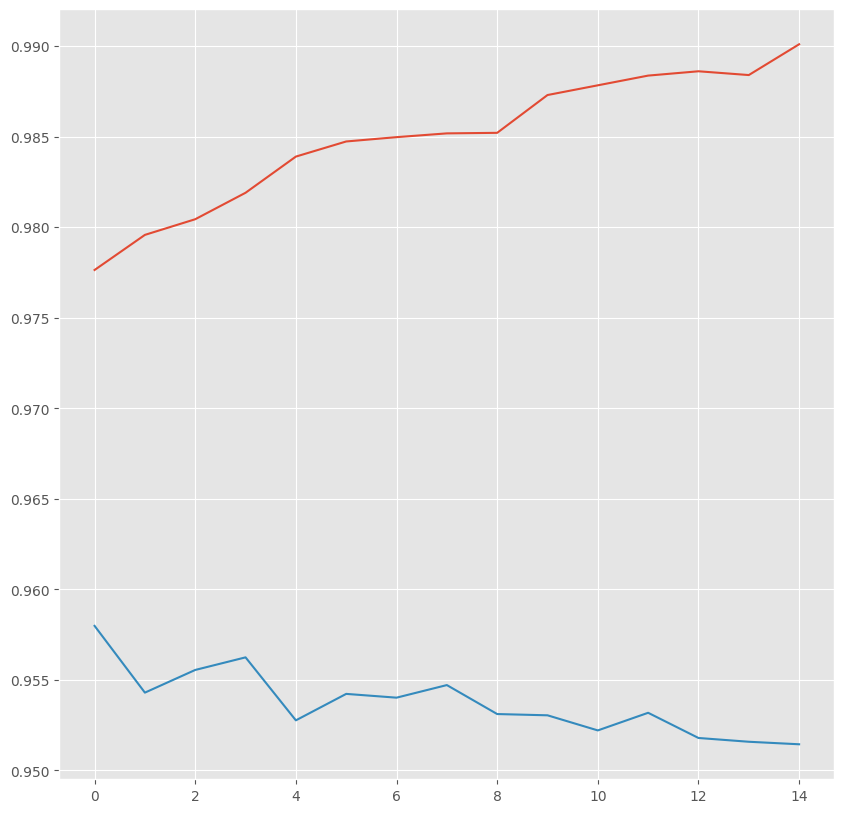

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(10,10))
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.show()

### prediction

In [ ]:
y_pred = model.predict([np.array(X_word_te),
                        np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))])

10/10 [==============================] - 0s 32ms/step


In [ ]:
i = 2
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word           ||True ||Pred
আহত            : O     O
ব্যক্তিদের     : O     O
স্থানীয়       : O     B-ORG
স্বাস্থ্য      : O     I-ORG
কমপ্লেক্স      : O     L-ORG
ও              : O     O
যশোর           : B-ORG B-ORG
জেনারেল        : I-ORG I-ORG
হাসপাতালে      : L-ORG L-ORG
ভর্তি          : O     O
করা            : O     O
হয়েছে         : O     O
।              : O     O


#### confusion matrix

In [ ]:
tags

['I-ORG',
 'I-LAW',
 'B-LAW',
 'B-PERSON',
 'U-ORG',
 'I-GPE',
 'L-ORG',
 'U-PERSON',
 'O',
 'I-PERSON',
 'U-GPE',
 'L-PERSON',
 'B-GPE',
 'U-DATE',
 'B-ORG',
 'L-GPE',
 'L-LAW']

In [ ]:
preds = np.argmax(y_pred, axis=-1)
pred = preds.flatten()
print(pred[:10])
pred = [idx2tag[t] for t in pred]
print(pred[:10])

[ 9 14  9  9  9  9  9  9  9 11]
['O', 'U-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'U-GPE']


In [ ]:
true = y_te.flatten()
print(true[:10])
true = [idx2tag[t] for t in true]
print(true[:10])

[ 9 14  9  9  9  9  9  9  9  9]
['O', 'U-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
label = tags

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

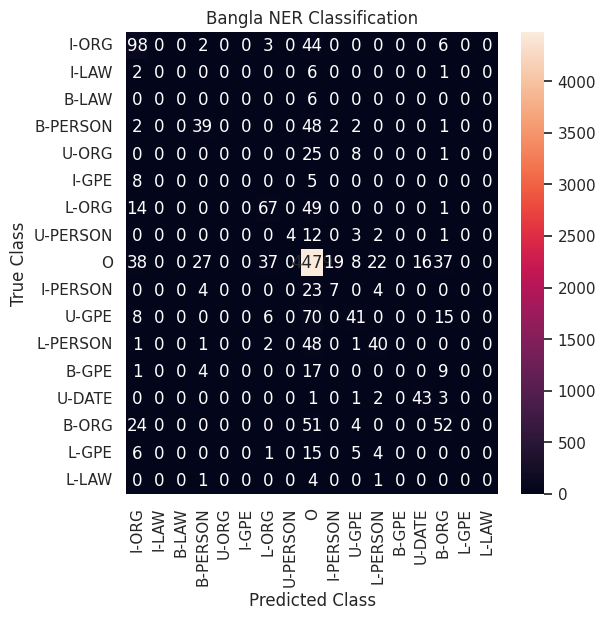

In [ ]:
cm = confusion_matrix(true, pred, labels=label)
sns.set(style='whitegrid', palette='bright', font_scale=1)
rcParams['figure.figsize'] = 14,8
plt.figure(figsize=(6,6))
sns_plt=sns.heatmap(cm, xticklabels=label, yticklabels=label, annot=True, fmt='d');
plt.title('Bangla NER Classification')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

### function for name extraction

In [ ]:
def extract_names(sentence):
  listed_s = wrd_punc_sprtr(sentence)

  # tokenization of words
  X_word = [[word2idx[w] for w in listed_s ]]

  # word/punctuation padding
  X_word = pad_sequences(maxlen = max_len, sequences=X_word, value=word2idx['PAD'], padding='post', truncating='post')

  # characters sequencing, tokenization and padding
  X_char = []
  sent_seq = []
  for i in range(max_len):
    word_seq = []
    for j in range(max_len_char):
      try:
        word_seq.append(char2idx.get(listed_s[i][j]))
      except:
        word_seq.append(char2idx.get('PAD'))
    sent_seq.append(word_seq)
  X_char.append(np.array(sent_seq))

  # predicting
  y_pred = model.predict([np.array(X_word),
                        np.array(X_char).reshape((len(X_char), max_len, max_len_char))])

  # showing the name
  i=0
  p = np.argmax(y_pred[i], axis=-1)
  name_list = []
  for w, pred in zip(X_word[i], p):
    # if w != 0:
    if idx2tag[pred] == 'B-PERSON' or idx2tag[pred] == 'I-PERSON' or idx2tag[pred] == 'L-PERSON':
      name_list.append(idx2word[w])
  if name_list == []:
    print('দুঃখিত, কোন নাম পাওয়া যায়নি!')
  else:
    name = ' '.join(name_list)
    print(name)

In [ ]:
extract_names('ব্যাংকের চেয়ারম্যান ও ঢাকা বিশ্ববিদ্যালয়ের ইন্টারন্যাশনাল বিজনেস বিভাগের অধ্যাপক খন্দকার বজলুল হক প্রথম আলো ডটকমকে জানান, বিকেল তিনটা ৫০ মিনিটে তিনি এ ধরনের অভিযোগ পেয়েছেন।')

1/1 [==============================] - 0s 46ms/step
অধ্যাপক খন্দকার বজলুল হক


### this block was used for testing

In [ ]:
for sentence in sentences:
  for wordtag in sentence:
    if wordtag[0] == 'আসলাম':
      print(sentence)

[('পুলিশ', 'O'), ('জানায়', 'O'), (',', 'O'), ('আসলাম', 'O'), ('গ্রামের', 'O'), ('বাড়ি', 'O'), ('থেকে', 'O'), ('বৃহস্পতিবার', 'U-DATE'), ('রাত', 'O'), ('আটটার', 'O'), ('দিকে', 'O'), ('মধুপুর', 'O'), ('থানার', 'O'), ('উদ্দেশে', 'O'), ('রওনা', 'O'), ('দেন', 'O'), ('।', 'O')]
[('চট্টগ্রাম', 'B-ORG'), ('জেলা', 'I-ORG'), ('ক্রীড়া', 'I-ORG'), ('সংস্থার', 'L-ORG'), ('অতিরিক্ত', 'O'), ('সাধারণ', 'O'), ('সম্পাদক', 'O'), ('ও', 'O'), ('চট্টগ্রাম', 'O'), ('মোহামেডান', 'O'), ('ক্লাবের', 'O'), ('কর্ণধার', 'O'), ('সৈয়দ', 'O'), ('শাহাবুদ্দিন', 'O'), ('শামীম', 'O'), ('প্রথম', 'O'), ('আলোকে', 'O'), ('জানান', 'O'), (',', 'O'), ('জাম্বুরি', 'O'), ('মাঠে', 'O'), ('কায়সার', 'O'), ('হামিদ', 'O'), (',', 'O'), ('শেখ', 'O'), ('আসলাম', 'O'), (',', 'O'), ('এফ', 'O'), ('আই', 'O'), ('কামালদের', 'O'), ('মতো', 'O'), ('জাতীয়', 'O'), ('ফুটবলাররা', 'O'), ('খেলেছেন', 'O'), ('।', 'O')]
[('এদিকে', 'O'), ('গতকাল', 'O'), ('সোমবার', 'O'), ('সকালে', 'O'), ('জনতা', 'B-ORG'), ('ব্যাংকের', 'L-ORG'), ('চেয়ারম্যান', 'O'), ('ড

In [ ]:
sentences[0][0]

('অগ্রণী', 'B-ORG')

In [ ]:
X_char[0][1]

array([10, 44, 67,  7, 82, 51, 42, 87,  0,  0,  0,  0,  0,  0,  0])

In [ ]:
print(sentences[0][1][0])
print(len(sentences[0][1][0]))
print(sentences[0][1][0][7])
print(char2idx.get(sentences[0][1][0][7]))

ব্যাংকের
8
র
87


In [ ]:
X_char[0][0]

array([52, 65, 44, 87, 85, 86,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [ ]:
print(sentences[0][0][0])
print(len(sentences[0][0][0]))
print(char2idx.get(sentences[0][0][0]))

অগ্রণী
6
None


In [ ]:
char2idx

{'ঈ': 2,
 'ঠ': 3,
 '৬': 4,
 'ঔ': 5,
 'ঙ': 6,
 'া': 7,
 'ট': 8,
 '৭': 9,
 'ব': 10,
 'চ': 11,
 'ন': 12,
 'ৈ': 13,
 'ষ': 14,
 'ঊ': 15,
 '৯': 16,
 '\xa0': 17,
 "'": 18,
 'ধ': 19,
 'ড': 20,
 'ঢ': 21,
 'ছ': 22,
 'স': 23,
 ':': 24,
 '?': 25,
 'ঝ': 26,
 'ৗ': 27,
 '(': 28,
 'ই': 29,
 'য়': 30,
 ';': 31,
 'ু': 32,
 '২': 33,
 'প': 34,
 ')': 35,
 'দ': 36,
 '—': 37,
 '৮': 38,
 '০': 39,
 '৫': 40,
 'জ': 41,
 'ে': 42,
 'হ': 43,
 '্': 44,
 'এ': 45,
 'ঋ': 46,
 'শ': 47,
 'ূ': 48,
 'ো': 49,
 '-': 50,
 'ক': 51,
 'অ': 52,
 'ভ': 53,
 'খ': 54,
 '়': 55,
 'ঐ': 56,
 'ল': 57,
 'ৌ': 58,
 'ম': 59,
 '.': 60,
 'ত': 61,
 'থ': 62,
 'ঁ': 63,
 'ফ': 64,
 'গ': 65,
 '।': 66,
 'য': 67,
 'ও': 68,
 'ঞ': 69,
 'আ': 70,
 'ি': 71,
 '৩': 72,
 'উ': 73,
 '৪': 74,
 'ৎ': 75,
 ',': 76,
 'ৃ': 77,
 '১': 78,
 '৷': 79,
 'ঘ': 80,
 'ঃ': 81,
 'ং': 82,
 'ড়': 83,
 '–': 84,
 'ণ': 85,
 'ী': 86,
 'র': 87,
 'UNK': 1,
 'PAD': 0}

In [ ]:
len(chars)

86

In [ ]:
# there are nonetypes in my X_char_tr
X_char_tr

[array([[87,  7, 23, 44, 61,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [36, 71, 30, 42,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [70, 23,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [67,  7, 68, 30,  7, 87,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [34, 62, 42,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [52, 12, 42, 51, 42, 29,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [36, 42, 54, 61, 42,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [36, 42, 54, 61, 42,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [11, 42, 43,  7, 87,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [59,  7, 62,  7, 30,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [65, 42, 63, 62, 42,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [87, 42, 54, 42, 22, 42, 12,  0,  0,  0,  0,  0,  0,  0,  0],
        [66,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,

In [ ]:
np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))

array([[[87,  7, 23, ...,  0,  0,  0],
        [36, 71, 30, ...,  0,  0,  0],
        [70, 23,  7, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[78, 38,  4, ...,  0,  0,  0],
        [23,  7, 57, ...,  0,  0,  0],
        [59, 30, 59, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[67, 32, 51, ..., 42, 87,  0],
        [10,  7, 82, ...,  0,  0,  0],
        [34, 44, 87, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       ...,

       [[59, 49,  8, ...,  0,  0,  0],
        [36,  7, 65, ...,  0,  0,  0],
        [10, 57, 61, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0

In [ ]:
np.array(X_word_tr).reshape(len(X_word_tr), max_len)

array([[ 2587,   878,  2651, ...,     0,     0,     0],
       [ 9942,  9444,  4955, ...,     0,     0,     0],
       [ 1733,  1440,   416, ...,     0,     0,     0],
       ...,
       [ 7347,  4600,  6492, ...,     0,     0,     0],
       [10431,   588,  9384, ...,     0,     0,     0],
       [ 2302,  1893, 11022, ...,     0,     0,     0]], dtype=int32)

In [ ]:
np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char)).shape

(2660, 60, 15)

In [ ]:
type(np.array(y_tr).reshape(len(y_tr), max_len, 1))

numpy.ndarray

In [ ]:
type(emb_word)

keras.engine.keras_tensor.KerasTensor

In [ ]:
type(word_in)

keras.engine.keras_tensor.KerasTensor

In [ ]:
type(X_char_tr)

list

In [ ]:
type(X_word_tr)

numpy.ndarray

In [ ]:
type(y_tr)

numpy.ndarray

In [ ]:
print([[[w[0]] for w in s] for s in sentences[:10]])

[[['অগ্রণী'], ['ব্যাংকের'], ['জ্যেষ্ঠ'], ['কর্মকর্তা'], ['পদে'], ['নিয়োগ'], ['পরীক্ষার'], ['প্রশ্নপত্র'], ['ফাঁসের'], ['অভিযোগ'], ['উঠেছে'], ['।']], [['ব্যাংকের'], ['চেয়ারম্যানও'], ['এ'], ['অভিযোগের'], ['সত্যতা'], ['স্বীকার'], ['করেছেন'], ['।']], [['এ'], ['ছাড়া'], ['বিষয়টি'], ['তদন্ত'], ['করাও'], ['জরুরি'], ['।']], [['তাঁর'], ['দেওয়া'], ['তথ্যের'], ['ভিত্তিতে'], ['গ্রেপ্তার'], ['করা'], ['হয়েছে'], ['চেন্নাই'], ['সুপার'], ['কিংসের'], ['প্রধান'], ['গুরুনাথ'], ['মায়াপ্পনকে'], ['।']], [['যাচাই'], ['করে'], ['সিদ্ধান্ত'], ['নেওয়া'], ['হবে'], ['।'], ["'"]], [['তবে'], ['রিট'], ['আবেদনকারী'], ['আইনজীবী'], ['মনজিল'], ['মোরসেদ'], ['প্রথম'], ['আলোকে'], ['বলেন'], [','], ["'"], ['সুপারিশ'], ['বাস্তবায়নে'], ['মামলা'], ['বাধা'], ['নয়'], ['।']], [['এ'], ['ব্যাপারে'], ['আমি'], ['সচিবসহ'], ['কয়েকজনকে'], ['চিঠি'], ['দিয়েছি'], ['।'], ["'"]], [['অভিযোগ'], [','], ['ওই'], ['কমিটিতেও'], ['খাজা'], ['জাকিসহ'], ['কয়েকজন'], ['স্থান'], ['করে'], ['নেওয়ায়'], ['এবং'], ['২০০৯'], ['সালের'], ['নির্বাচনে'], 

In [ ]:
print([[[w[1]] for w in s] for s in sentences[:10]])

[[['B-ORG'], ['L-ORG'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O']], [['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O']], [['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O']], [['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['B-ORG'], ['I-ORG'], ['L-ORG'], ['O'], ['B-PERSON'], ['L-PERSON'], ['O']], [['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O']], [['O'], ['O'], ['O'], ['O'], ['B-PERSON'], ['L-PERSON'], ['B-ORG'], ['L-ORG'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O']], [['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O']], [['O'], ['O'], ['O'], ['O'], ['B-PERSON'], ['L-PERSON'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O']], [['O'], ['O'], ['O'], ['U-GPE'], ['B-GPE'], ['I-GPE'], ['L-GPE'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['B-PERSON'], ['L-PERSON'], ['O'], ['B-PERSON'], ['I-PERSON'], ['L-PERSON'], ['O'], ['O'], ['O'], ['O'], ['B-PERSON'], 

In [ ]:
sentences

[[('অগ্রণী', 'B-ORG'),
  ('ব্যাংকের', 'L-ORG'),
  ('জ্যেষ্ঠ', 'O'),
  ('কর্মকর্তা', 'O'),
  ('পদে', 'O'),
  ('নিয়োগ', 'O'),
  ('পরীক্ষার', 'O'),
  ('প্রশ্নপত্র', 'O'),
  ('ফাঁসের', 'O'),
  ('অভিযোগ', 'O'),
  ('উঠেছে', 'O'),
  ('।', 'O')],
 [('ব্যাংকের', 'O'),
  ('চেয়ারম্যানও', 'O'),
  ('এ', 'O'),
  ('অভিযোগের', 'O'),
  ('সত্যতা', 'O'),
  ('স্বীকার', 'O'),
  ('করেছেন', 'O'),
  ('।', 'O')],
 [('এ', 'O'),
  ('ছাড়া', 'O'),
  ('বিষয়টি', 'O'),
  ('তদন্ত', 'O'),
  ('করাও', 'O'),
  ('জরুরি', 'O'),
  ('।', 'O')],
 [('তাঁর', 'O'),
  ('দেওয়া', 'O'),
  ('তথ্যের', 'O'),
  ('ভিত্তিতে', 'O'),
  ('গ্রেপ্তার', 'O'),
  ('করা', 'O'),
  ('হয়েছে', 'O'),
  ('চেন্নাই', 'B-ORG'),
  ('সুপার', 'I-ORG'),
  ('কিংসের', 'L-ORG'),
  ('প্রধান', 'O'),
  ('গুরুনাথ', 'B-PERSON'),
  ('মায়াপ্পনকে', 'L-PERSON'),
  ('।', 'O')],
 [('যাচাই', 'O'),
  ('করে', 'O'),
  ('সিদ্ধান্ত', 'O'),
  ('নেওয়া', 'O'),
  ('হবে', 'O'),
  ('।', 'O'),
  ("'", 'O')],
 [('তবে', 'O'),
  ('রিট', 'O'),
  ('আবেদনকারী', 'O'),
  ('আইনজীবী', 'O')

In [ ]:
X_word

array([[10023,  1978,   334, ...,     0,     0,     0],
       [ 1978,  3902,  7271, ...,     0,     0,     0],
       [ 7271,   538,  3228, ...,     0,     0,     0],
       ...,
       [ 7271,   538,  4375, ...,     0,     0,     0],
       [ 4438,  3575,  9648, ...,     0,     0,     0],
       [10924,  5631,   510, ...,     0,     0,     0]], dtype=int32)

In [ ]:
word2idx

{'প্রশাসন': 2,
 'গুলির': 3,
 'ফায়েক': 4,
 'হুমায়ুন': 5,
 'আমলা': 6,
 "'রোজা'": 7,
 'মিকাইল': 8,
 'শুধুই': 9,
 'সম্পর্কিত': 10,
 'কয়লাখনি': 11,
 'বিএনডব্লিউএলএর': 12,
 'পেকুয়া': 13,
 'একর': 14,
 'অংশগ্রহণের': 15,
 'সুবিধাভোগী': 16,
 'দরদালান': 17,
 'বলব': 18,
 'প্রেস': 19,
 'বিশ্বশক্তি': 20,
 'প্রতিষ্ঠায়': 21,
 'ফেলে': 22,
 'সুপার': 23,
 'এলাকায়': 24,
 'কমিশনের': 25,
 '২৪৪টি': 26,
 'গণতন্ত্রের': 27,
 'চাইলেও': 28,
 'পাঠাবে': 29,
 'দেশটিতে': 30,
 'পরিদর্শন': 31,
 'সাপোর্ট': 32,
 'করিয়ে': 33,
 'পুনর্জন্মে': 34,
 'সম্মেলনকক্ষে': 35,
 'ওনলি': 36,
 'ই': 37,
 'স্টাডি': 38,
 '২৫৪': 39,
 'নেতৃত্ব': 40,
 'স্কপের': 41,
 'সাফল্যের': 42,
 'বেতনভোগী': 43,
 'ছাত্রদল': 44,
 'বেশ': 45,
 'ম্যাকার্থি': 46,
 'রেস্তোরাঁয়': 47,
 'খুঁটির': 48,
 'বীরশ্রেষ্ঠ': 49,
 'ডাটাবিজ': 50,
 'মিজৌরি': 51,
 'বিপাকে': 52,
 'অবমাননা': 53,
 'ভাষায়': 54,
 'মাধুরী': 55,
 'সংকেত': 56,
 'জনমিতিতে': 57,
 'পাসের': 58,
 'শাখায়': 59,
 'চূড়ান্তকরণ': 60,
 'জারির': 61,
 'বাড়িতেই': 62,
 'দিবাগত': 63,
 'সালিংগার': 64,
 'পর্যায়ে

In [ ]:
tag2idx

{'L-GPE': 1,
 'U-DATE': 2,
 'U-ORG': 3,
 'B-GPE': 4,
 'B-ORG': 5,
 'U-GPE': 6,
 'L-ORG': 7,
 'I-LAW': 8,
 'O': 9,
 'B-LAW': 10,
 'L-LAW': 11,
 'I-ORG': 12,
 'B-PERSON': 13,
 'I-GPE': 14,
 'I-PERSON': 15,
 'L-PERSON': 16,
 'U-PERSON': 17,
 'PAD': 0}

In [ ]:
agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                    s["tag"].values.tolist())]
grouped = df.groupby("sentence").apply(agg_func)
sentences = [s for s in grouped]

In [ ]:
sentences[0]

[('অগ্রণী', 'B-ORG'),
 ('ব্যাংকের', 'L-ORG'),
 ('জ্যেষ্ঠ', 'O'),
 ('কর্মকর্তা', 'O'),
 ('পদে', 'O'),
 ('নিয়োগ', 'O'),
 ('পরীক্ষার', 'O'),
 ('প্রশ্নপত্র', 'O'),
 ('ফাঁসের', 'O'),
 ('অভিযোগ', 'O'),
 ('উঠেছে', 'O'),
 ('।', 'O')]

In [ ]:
n_set = 0
s = grouped["sentence {}".format(n_set)]
s

[('অগ্রণী', 'B-ORG'),
 ('ব্যাংকের', 'L-ORG'),
 ('জ্যেষ্ঠ', 'O'),
 ('কর্মকর্তা', 'O'),
 ('পদে', 'O'),
 ('নিয়োগ', 'O'),
 ('পরীক্ষার', 'O'),
 ('প্রশ্নপত্র', 'O'),
 ('ফাঁসের', 'O'),
 ('অভিযোগ', 'O'),
 ('উঠেছে', 'O'),
 ('।', 'O')]